## Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pydicom
from tqdm import tqdm
import skimage
from skimage import data, io
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets
from ipywidgets import interact
from random import randint

print(f'pydicom=={pydicom.__version__}')
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'ipywidgets=={ipywidgets.__version__}')
print(f'skimage=={skimage.__version__}')
print(f'matplotlib=={matplotlib.__version__}')

pydicom==2.3.0
numpy==1.23.2
pandas==1.4.4
ipywidgets==8.0.2
skimage==0.19.3
matplotlib==3.5.3


## Necessary Paths

In [2]:
# project path
project_path = Path.cwd().parent
# MRI data folder path
data_path = project_path/'data/dicom'
# Cardiovascular Disease file path
cvd_path = project_path/'data/csv/conditions.csv'

In [3]:
dcm_files = list(data_path.glob('*.dcm'))
print(f'Found {len(dcm_files)} .dcm images')

Found 298 .dcm images


Let's pick a random image

In [4]:
i = randint(0, len(dcm_files)-1)
dcm_fname = dcm_files[i]
print(f'We are inspecting the file `{dcm_fname}`')

We are inspecting the file `/home/dk/Desktop/projects/multimodal-healthcare/mri/data/dicom/Dennis979_Upton904_2dd0e748-a4a5-3632-5d15-e60a08400c4e1.2.840.99999999.18177039.662436542172.dcm`


## MRI Data Exploration

MRI data (after processed) will be the one modal input of the network

### Read one image and visualize

In [5]:
try:
    dcm = pydicom.dcmread(dcm_fname)
    print(type(dcm))
except FileNotFoundError:
    print ('error during file read ', dcm_fname)

<class 'pydicom.dataset.FileDataset'>


In [6]:
# convert DICOM into numerical numpy array of pixel intensity values
img = dcm.pixel_array
print(f'img shape: {img.shape}')

img shape: (256, 256, 256)


### Plotting the MRI image

Run the code below multiple times to randomly plot different slices

Plotting slice 46 of the image


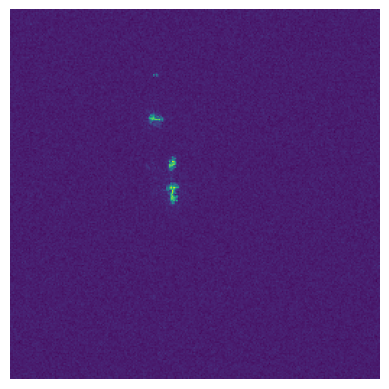

In [7]:
# Select random layer number
maxval = 255
i = np.random.randint(0, maxval)
print(f"Plotting slice {i} of the image")
plt.imshow(img[:, :, i])
plt.axis('off');

Some slices contain only noise, and they have big L2 norm

L2 norm = 133.38


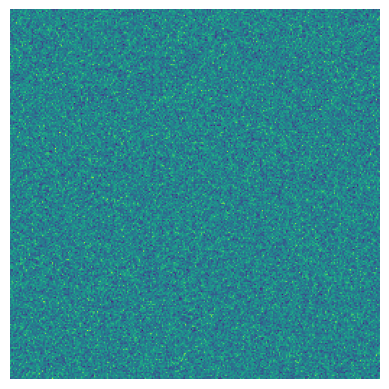

In [8]:
from numpy import linalg as LA

a = img[:, :, 10]
a = a.astype(float) / a.max()  # rescale
plt.imshow(a)
plt.axis('off');
print(f'L2 norm = {LA.norm(a):.2f}')

A slice that contains the brain. It has smaller L2 norm 

L2 norm = 77.98


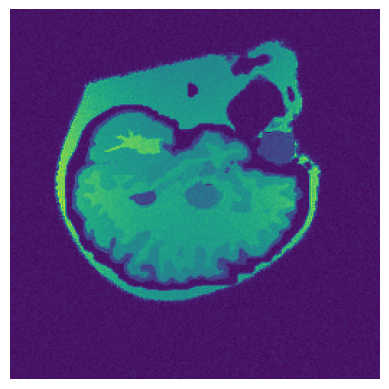

In [9]:
b = img[:, :, 100]
b = b.astype(float) / b.max()
plt.imshow(b)
plt.axis('off');
print(f'L2 norm = {LA.norm(b):.2f}')

Interactive Exploration

In [10]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(5, 3))
    channel = 0
    plt.imshow(img[:, :, layer]);
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data among the depth dimension
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=127, description='layer', max=255), Output()), _dom_classes=('widget-int…

We can see that slices with indices in the range of 0-55 and 200-255 contains noise

### MRI Data processing 

Let's loop through all the MRI scans and remove the slices that contain only noises

In [11]:
for file in dcm_files:
    try:
        print(file.name)
        dcm = pydicom.dcmread(file)
        img = dcm.pixel_array
        print(img.shape)
    except FileNotFoundError:
        print ('error during file read ', dcm_fname)
    break

Charlette938_Runolfsson901_e8116fd7-c1a4-ddca-c425-6c63cb9ab2ec1.2.840.99999999.73920120.1192398818819.dcm
(256, 256, 256)


In [12]:
# convert uint16 datatype to float, scaled properly for uint8
# img = img.astype(float) / img.max() * 255.

# convert from float -> uint8
# img = img.astype(np.uint8)

# scale into [0, 1]
img = img.astype(float) / img.max()
img

array([[[0.06199741, 0.0509041 , 0.05099565, ..., 0.0654612 ,
         0.04499886, 0.07092393],
        [0.0684062 , 0.03550774, 0.06280613, ..., 0.09369039,
         0.05243   , 0.06990158],
        [0.05004959, 0.09262226, 0.0708629 , ..., 0.05821317,
         0.05574121, 0.0640116 ],
        ...,
        [0.06271458, 0.07055772, 0.04739452, ..., 0.05120928,
         0.07229725, 0.06263828],
        [0.06222629, 0.07486076, 0.07499809, ..., 0.05836576,
         0.0692607 , 0.0684062 ],
        [0.08513008, 0.07968261, 0.05795377, ..., 0.05156023,
         0.04112306, 0.09623865]],

       [[0.04257267, 0.06422522, 0.0527657 , ..., 0.06662089,
         0.0531014 , 0.06413367],
        [0.06845197, 0.04251164, 0.03889525, ..., 0.07064927,
         0.05723659, 0.04492256],
        [0.05944915, 0.04765393, 0.05806058, ..., 0.06172274,
         0.073579  , 0.08461128],
        ...,
        [0.07785153, 0.06062409, 0.08625925, ..., 0.08937209,
         0.06709392, 0.03436332],
        [0.0

In [13]:
# invert image if necessary, according to DICOM metadata
img_type = dcm.PhotometricInterpretation
print(img_type)

if img_type == "MONOCHROME1":
  img = np.invert(img)

MONOCHROME2


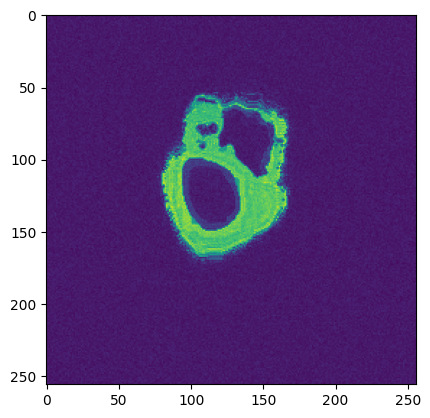

In [14]:
plt.imshow(img[:, :, 195])
plt.show()

In [15]:
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=127, description='layer', max=255), Output()), _dom_classes=('widget-int…

## Cardiovascular Disease Data Exploration

### Load patients, encouters and their conditions

In [16]:
conditions_df = pd.read_csv(cvd_path)
conditions_df

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1991-06-23,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,03bc904a-c655-0580-a620-264b065c01e6,162864005,Body mass index 30+ - obesity (finding)
1,2001-04-22,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,7cfc42ac-357a-c88e-1275-9d63f900b7d8,15777000,Prediabetes
2,2003-04-27,NaN,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,d3cbf195-f49a-24f5-fe79-c6dc21fb92da,271737000,Anemia (disorder)
3,1993-10-09,NaN,b8eb8d31-1031-fb5b-e207-b9815f80744c,42dbe56f-5b30-38b3-5634-a9b1a0206e44,59621000,Hypertension
4,2011-09-01,2011-09-15,8b0484cd-3dbd-8b8d-1b72-a32f74a5a846,92ad6010-058a-0362-d0df-86fcad3edf80,70704007,Sprain of wrist
...,...,...,...,...,...,...
35869,1965-11-21,NaN,3107760e-1dce-a177-4122-725241aae61a,9610387f-2967-e8b0-9494-487b83e5cae6,55822004,Hyperlipidemia
35870,1998-10-25,NaN,3107760e-1dce-a177-4122-725241aae61a,426364ce-8c69-9376-879f-bfa1f092474e,49436004,Atrial Fibrillation
35871,2001-03-11,NaN,3107760e-1dce-a177-4122-725241aae61a,647f0c30-bcdc-01e7-7392-0ac50ef428f3,230690007,Stroke
35872,2012-06-03,NaN,3107760e-1dce-a177-4122-725241aae61a,57450a36-26f1-18e1-fa9c-d7f9a01e78b6,53741008,Coronary Heart Disease


Let's see how many unique conditions are there in the dataset

In [17]:
description = conditions_df['DESCRIPTION']
print(f'there are {len(set(description))} different conditions, some examples are {list(set(description))[:5]}')

there are 152 different conditions, some examples are ['Pneumonia', 'Carcinoma in situ of prostate (disorder)', 'Childhood asthma', 'Laceration of forearm', 'Diabetic retinopathy associated with type II diabetes mellitus (disorder)']


### Cardiovascular Diseases (CVD)

The cardiovascular diseases found in the dataset are:

- Cardiac Arrest
- Chronic congestive heart failure (disorder)
- Coronary Heart Disease
- Myocardial Infarction
- Stroke

In [18]:
cvd_conditions = ['Cardiac Arrest', 'Chronic congestive heart failure (disorder)', 
                  'Coronary Heart Disease', 'Myocardial Infarction',
                  'Stroke']

### Explore patients and encouters

In [19]:
patient_ids = set(conditions_df['PATIENT'])
print(f'there are {len(patient_ids)} unique patients in total')

there are 3535 unique patients in total


In [20]:
encounter_ids = set(conditions_df['ENCOUNTER'])
print(f'there are {len(encounter_ids)} unique encounters in total')

there are 31091 unique encounters in total


### Retain only rows in `conditions_df` that contain CVD

In [21]:
cvd_df = []
for c in cvd_conditions:
    df = conditions_df.loc[conditions_df['DESCRIPTION'] == c]
    cvd_df.append(df)
cvd_df = pd.concat(cvd_df)

In [22]:
cvd_df

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
168,1999-01-29,NaN,6f4d77e9-2203-03a3-8966-92a22a21000a,0c62aae4-c10b-4d30-0091-4cb1f3422b55,410429000,Cardiac Arrest
323,2019-06-23,NaN,8ae88d45-4998-cf3b-6cf4-2d1f9d1324c6,271fd10b-52bd-ee51-510a-13ae97b721f2,410429000,Cardiac Arrest
377,1972-09-09,NaN,6d1f2671-e6a0-a415-5373-3a2bda361932,183267ec-5579-d320-c6ed-fb4cd33fb8e7,410429000,Cardiac Arrest
826,1986-10-26,NaN,62d625d2-f8fa-2f32-0ea0-5dc36f0a9a3f,d92b49e3-5f00-496a-5bd8-82f48be06dea,410429000,Cardiac Arrest
903,1995-07-01,NaN,2440c23e-0661-3dd8-8468-aa8631d24495,34a81031-2fdb-e293-641c-4bd92e31f4c8,410429000,Cardiac Arrest
...,...,...,...,...,...,...
35681,1951-06-07,NaN,384457c2-1624-7d76-09d3-22978fff2f36,157683c9-26ff-32f8-21eb-152f02243fa0,230690007,Stroke
35721,1994-09-18,NaN,6fcd3b00-0ef7-49d8-de16-3258bec968ee,d7934696-d8cd-3847-83c7-7fc9044a2bfd,230690007,Stroke
35732,1990-04-16,NaN,91dcb4fb-fe99-4235-9193-23001c49352f,b94d2557-d3e1-de90-b3f9-07c12fd25902,230690007,Stroke
35818,2008-07-14,NaN,bc0cb6be-1caa-e53f-f4c4-e25d91363698,01ced9b1-45ef-5347-dfdc-bda02ca290e7,230690007,Stroke


In [23]:
print(f'There are {len(cvd_df)} data samples with CVD conditions')

There are 2071 data samples with CVD conditions


Save the result to `.csv` file

In [24]:
cvd_df.to_csv(project_path/'data/processed/cvd.csv')

## Match MRI and Conditions (input and output)

Let's get the patient IDs for the patients with MRI scans. The IDs are included in the file name of each `.dcm` file, so we need to split the file names to get them

In [25]:
dicom_patient_ids = []
for f in dcm_files:
    s = str(f.name).split('_')[2]
    id = s.split('1.2.')[0]
    dicom_patient_ids.append(id)

Find out the number of CVD patients that have MRI scans

In [26]:
cvd_patient_ids = cvd_df['PATIENT']
cvd_dicom_ids = set(dicom_patient_ids).intersection(set(cvd_patient_ids))

print(f'number of patients that have MRI scan is {len(set(dicom_patient_ids))}')
print(f'number of CVD patients is {len(set(cvd_patient_ids))}')
print(f'number of CVD patients that have MRI scan is {len(cvd_dicom_ids)}')

number of patients that have MRI scan is 298
number of CVD patients is 1482
number of CVD patients that have MRI scan is 203


## References

https://github.com/mazurowski-lab/MRI-deeplearning-tutorial